In [1]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
hl.init() 

Running on Apache Spark version 2.4.4
SparkUI available at http://758a139ed0f9:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/tutorial/perf/hail-20200129-1648-0.2.30-2ae07d872f43.log


In [2]:
def get_path(n):
    return '/tmp/mt_{:08d}.mt'.format(n)

def write_mt(n):
    mt = hl.balding_nichols_model(n_populations=1, n_samples=n, n_variants=n)
    mt.write(get_path(n), overwrite=True)
    
def get_mt(n):
    return hl.read_matrix_table(get_path(n))

def do_col_agg(mt):
    mt = mt.annotate_cols(het_rate=hl.agg.fraction(mt.GT.is_het()))
    return mt.aggregate_cols(hl.agg.stats(mt.het_rate))

def do_row_agg(mt):
    mt = mt.annotate_rows(het_rate=hl.agg.fraction(mt.GT.is_het()))
    return mt.aggregate_rows(hl.agg.stats(mt.het_rate))

In [3]:
df = []
for n in [1000, 2500, 5000, 10000, 25000, 50000, 75000]:
    print("Running RC aggregation benchmarks for {n}x{n} MT".format(n=n))
    # Write the random NxN dataset out to disk
    mt = write_mt(n)
    
    # NOTE: Running this with either ordering of aggregations gives the same results
    for i in range(3):
        # Time row aggregations
        mt = get_mt(n)
        rt = %timeit -q -n 1 -r 1 -o do_row_agg(mt)
        mt.unpersist()
        
        # Time column aggregations
        mt = get_mt(n)
        ct = %timeit -q -n 1 -r 1 -o do_col_agg(mt)
        mt.unpersist()
        
        df.append(dict(n=n, i=i+1, rt=rt.best, ct=ct.best))
df = pd.DataFrame(df)

2020-01-29 16:48:38 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 1000 samples, and 1000 variants...


Running RC aggregation benchmarks for 1000x1000 MT


2020-01-29 16:48:39 Hail: INFO: Coerced sorted dataset
2020-01-29 16:48:40 Hail: INFO: wrote matrix table with 1000 rows and 1000 columns in 8 partitions to /tmp/mt_00001000.mt


Running RC aggregation benchmarks for 2500x2500 MT


2020-01-29 16:48:43 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 2500 samples, and 2500 variants...
2020-01-29 16:48:43 Hail: INFO: Coerced sorted dataset
2020-01-29 16:48:44 Hail: INFO: wrote matrix table with 2500 rows and 2500 columns in 8 partitions to /tmp/mt_00002500.mt


Running RC aggregation benchmarks for 5000x5000 MT


2020-01-29 16:48:46 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 5000 samples, and 5000 variants...
2020-01-29 16:48:47 Hail: INFO: Coerced sorted dataset
2020-01-29 16:48:49 Hail: INFO: wrote matrix table with 5000 rows and 5000 columns in 25 partitions to /tmp/mt_00005000.mt


Running RC aggregation benchmarks for 10000x10000 MT


2020-01-29 16:48:51 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 10000 samples, and 10000 variants...
2020-01-29 16:48:52 Hail: INFO: Coerced sorted dataset
2020-01-29 16:48:59 Hail: INFO: wrote matrix table with 10000 rows and 10000 columns in 100 partitions to /tmp/mt_00010000.mt


Running RC aggregation benchmarks for 25000x25000 MT


2020-01-29 16:49:03 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 25000 samples, and 25000 variants...
2020-01-29 16:49:05 Hail: INFO: Coerced sorted dataset
2020-01-29 16:49:38 Hail: INFO: wrote matrix table with 25000 rows and 25000 columns in 625 partitions to /tmp/mt_00025000.mt


Running RC aggregation benchmarks for 50000x50000 MT


2020-01-29 16:49:55 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 50000 samples, and 50000 variants...
2020-01-29 16:50:01 Hail: INFO: Coerced sorted dataset
2020-01-29 16:52:02 Hail: INFO: wrote matrix table with 50000 rows and 50000 columns in 2500 partitions to /tmp/mt_00050000.mt


Running RC aggregation benchmarks for 75000x75000 MT


2020-01-29 16:53:04 Hail: INFO: balding_nichols_model: generating genotypes for 1 populations, 75000 samples, and 75000 variants...
2020-01-29 16:53:12 Hail: INFO: Coerced sorted dataset
2020-01-29 16:57:43 Hail: INFO: wrote matrix table with 75000 rows and 75000 columns in 5625 partitions to /tmp/mt_00075000.mt


In [4]:
df.head()

,n,i,rt,ct
0,1000,1,0.638193,0.599878
1,1000,2,0.178710,0.315669
2,1000,3,0.146758,0.301173
3,2500,1,0.181651,0.372839
4,2500,2,0.150685,0.436345


In [6]:
dft = df.set_index(['n', 'i']).rename_axis('axis', axis='columns').stack().rename('time').reset_index()
dft['axis'] = dft['axis'].map({
    'ct': 'Column Aggregation (across rows)',
    'rt': 'Row Aggregation (across cols)'
})
dft.head()

,n,i,axis,time
0,1000,1,Row Aggregation (across cols),0.638193
1,1000,1,Column Aggregation (across rows),0.599878
2,1000,2,Row Aggregation (across cols),0.178710
3,1000,2,Column Aggregation (across rows),0.315669
4,1000,3,Row Aggregation (across cols),0.146758


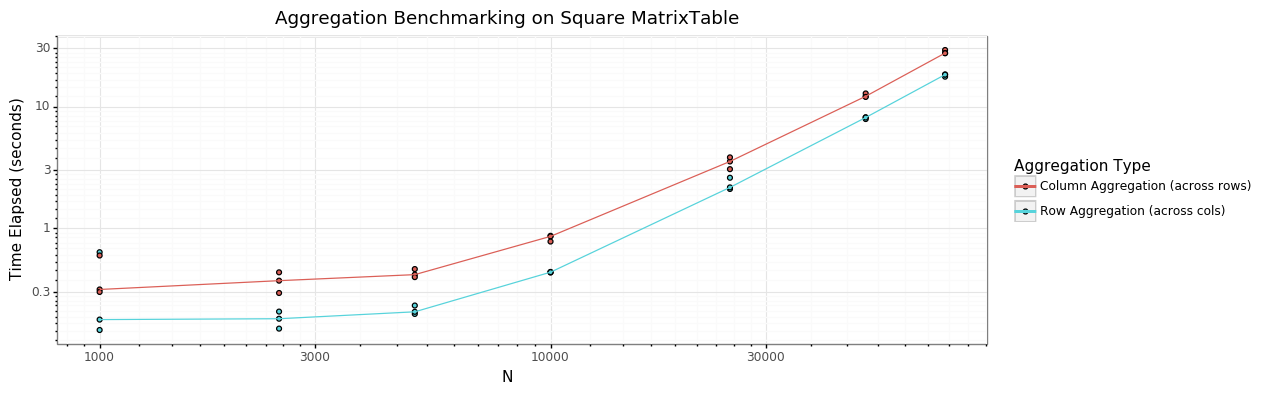

<ggplot: (8766821292437)>

In [10]:
(
    pn.ggplot(
        dft.assign(i=lambda df: df['i'].astype(str)),
        pn.aes(x='n', y='time', fill='axis') 
    ) + 
    pn.geom_point() + 
    pn.geom_line(
        mapping=pn.aes(x='n', y='time', group='axis', color='axis'), 
        data=dft.groupby(['n', 'axis'])['time'].median().rename('time').reset_index()
    ) +
    pn.scale_x_log10() + 
    pn.scale_y_log10() + 
    pn.labs(x='N', y='Time Elapsed (seconds)', fill='Aggregation Type', color='Aggregation Type') + 
    pn.ggtitle('Aggregation Benchmarking on Square MatrixTable') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(12, 4))
)